# Download and grid gravity point data
We follow Geoscience Australia's geophys_utils package examples to query the netcdf database of gravity point data.

If this is the first time running this in your venv, clone and install [geophys_utils](https://github.com/GeoscienceAustralia/geophys_utils) using `pip install -e path\to\geophys_utils`

You may also need to hack in the examples code, e.g. by `%cd geophys_utils\examples`

## Semi-automatic gridding
Luke Smith

We want to:
1. Query GA for point and line data over an extent with decent gravity coverage.
1. Compile the netCDF files available - i.e., identify each survey
1. Plot the point data and colour by value/survey/etc
1. Grid the data - at different cell sizes.



In [1]:
%matplotlib inline

from pathlib import Path

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import colorcet as cc
import harmonica as hm
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
import pooch
import pyproj
import verde as vd
import xarray as xr

from geophys_utils import NetCDFPointUtils, CSWUtils
from geophys_utils import get_spatial_ref_from_wkt, get_utm_wkt, transform_coords

In [2]:
# From CSW data discovery example 1
cswu = CSWUtils("https://ecat.ga.gov.au/geonetwork/srv/eng/csw")

## grav
# theme = "Gravity"
# keywords = "point, gravity, point located data, ground digital data, geophysical survey"  # Comma-separated list of keywords
# GDA94_bounds = (141.0, -32.2, 141.6, -31.7) # Broken Hill, NSW

## mag
theme = "Magnetics"
keywords = "AWAGS, Line, Magnetic, Magnetics, airborne digital data, geophysical survey"
GDA94_bounds = (143.94, -36, 147.05, -34.01) # Hay, Narrandera, Deniliquin, Jerilderie, NSW

record_generator = cswu.query_csw(
    keyword_list=keywords,
    # anytext_list=allwords,
    # titleword_list=titlewords,
    bounding_box=GDA94_bounds,
    # start_datetime=start_date,
    # stop_datetime=end_date,
    # max_total_records=2000
)

nc_paths = [
    distribution["url"] for distribution in cswu.get_netcdf_urls(record_generator)
]

registry = {Path(nc_path).name: None for nc_path in nc_paths}
urls = {
    Path(nc_path).name: "https://dapds00.nci.org.au/thredds/fileServer/" + nc_path[41:]
    for nc_path in nc_paths
}
print(f"Found {len(nc_paths)} matching netCDFs")

doggo = pooch.create(
    path=f"C:/Luke/data/pooch/{theme}",
    base_url="",
    registry=registry,
    urls=urls,
)

files = [doggo.fetch(stick) for stick in doggo.registry_files]
print(f"Fetched {len(files)} files, woof!")


Found 27 matching netCDFs
Fetched 27 files, woof!


In [3]:
## From geophys_utils "new" Example 9
# Create NetCDFPointUtils object for specified netCDF dataset


def rescale_array(input_np_array, new_range_min=0, new_range_max=1):
    old_min = input_np_array.min()
    old_range = input_np_array.max() - old_min
    new_range = new_range_max - new_range_min

    return ((input_np_array - old_min) / old_range * new_range) + new_range_min


def plot_survey_points(
    netcdf_path, variable_to_map, colour_scheme="cet_CET_L16", fillval_fix=False
):

    nc = netCDF4.Dataset(str(netcdf_path) + ("#fillmismatch" if fillval_fix else ""))
    npu = NetCDFPointUtils(nc)
    print(npu.xycoords[:])

    utm_wkt, utm_coords = npu.utm_coords(npu.xycoords[:])
    utm_zone = get_spatial_ref_from_wkt(
        utm_wkt
    ).GetUTMZone()  # -ve for Southern Hemisphere
    southern_hemisphere = utm_zone < 0
    utm_zone = abs(utm_zone)
    projection = ccrs.UTM(zone=utm_zone, southern_hemisphere=southern_hemisphere)

    # print(nc.variables)
    variable = nc.variables[variable_to_map][:]
    colour_array = rescale_array(variable, 0, 1)

    # map_image = cimgt.OSM()# http://developer.mapquest.com/web/products/open/map for terms of use
    # map_image = cimgt.StamenTerrain() # http://maps.stamen.com/
    map_image = cimgt.QuadtreeTiles(desired_tile_form="RGB")  # PIL image mode
    fig = plt.figure(figsize=(30, 20))

    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.set_title(f"Point {theme} Survey - {nc.getncattr('title')}")
    ax.add_image(map_image, 10)

    # set the x and y axis tick values
    x_min = np.min(utm_coords[:, 0])
    x_max = np.max(utm_coords[:, 0])
    y_min = np.min(utm_coords[:, 1])
    y_max = np.max(utm_coords[:, 1])

    range_x = x_max - x_min
    range_y = y_max - y_min
    ax.set_xticks([x_min, range_x / 2 + x_min, x_max])
    ax.set_yticks([y_min, range_y / 2 + y_min, y_max])

    # set the x and y axis labels
    ax.set_xlabel("Eastings (m)", rotation=0, labelpad=20)
    ax.set_ylabel("Northings (m)", rotation=90, labelpad=20)

    # See link for possible colourmap schemes: https://matplotlib.org/examples/color/colormaps_reference.html
    cm = plt.cm.get_cmap(colour_scheme)

    # build a scatter plot of the specified data, define marker, spatial reference system, and the chosen colour map type
    sc = ax.scatter(
        utm_coords[:, 0],
        utm_coords[:, 1],
        marker="o",
        c=colour_array,
        s=4,
        alpha=0.9,
        transform=projection,
        cmap=cm,
    )

    # set the colour bar ticks and labels
    cb = plt.colorbar(sc, ticks=[0, 1])
    cb.set_label("Magnetic units" if "Mag" in theme else "Free air Gravity (um/s^2)")
    cb.ax.set_yticklabels(
        [str(np.min(variable)), str(np.max(variable))]
    )  # vertically oriented colorbar

    plt.show()


In [4]:
def dataset_value_generator(
    variable_name_list, dataset_list, bounding_box, min_points=None, max_points=None
):
    """
    Generator yielding coordinates and values of the specified variable
    for all points from the supplied dataset list which fall within bounds
    """
    line_dataset_count = 0
    for dataset in dataset_list:
        line_data = {}
        try:
            nc_dataset = netCDF4.Dataset(dataset)
            # Note work-around for bad _FillValue: https://github.com/Unidata/netcdf-c/issues/1299
            netcdf_point_utils = NetCDFPointUtils(nc_dataset)

            # print netcdf_point_utils.__dict__
            # print(nc_dataset.variables.keys())

            # print('Computing spatial mask')
            spatial_mask = netcdf_point_utils.get_spatial_mask(
                bounding_box, bounds_wkt=netcdf_point_utils.wkt
            )

            point_count = np.count_nonzero(spatial_mask)

            print(
                "{}/{} points found in bounding box for {}".format(
                    point_count, netcdf_point_utils.point_count, dataset
                )
            )

            if not point_count:
                continue

            # Enforce min/max point counts
            if min_points and point_count < min_points:
                print("Skipping dataset with < {} points".format(min_points))
                continue
            if max_points and point_count > max_points:
                print("Skipping dataset with > {} points".format(max_points))
                continue

            dataset_value_dict = {
                "coordinates": netcdf_point_utils.xycoords[spatial_mask]
            }

            # Read all variable attributes and values
            for variable_name in variable_name_list:
                variable = nc_dataset.variables[variable_name]
                if variable.dimensions[0] != "point":
                    # Variable is NOT of point dimension - must be lookup
                    dataset_value_dict[
                        variable_name
                    ] = netcdf_point_utils.expand_lookup_variable(
                        lookup_variable_name=variable_name, mask=spatial_mask
                    )
                else:  # 'point' is in variable.dimensions - "normal" variable
                    dataset_value_dict[variable_name] = variable[:][spatial_mask]

            yield dataset, dataset_value_dict

        except Exception as e:
            print("Unable to read point dataset {}: {}".format(dataset, e))

            yield dataset, dataset_value_dict


In [5]:
# Retrieve all points in bounding box from NetCDF files in UTM projection
# Lines will be filtered to exclude tielines by using "flight_lines_only=True"

grid_var = "mag_awagsLevelled" if "Mag" in theme else "freeair"

dataset_values = {
    dataset: dataset_value_dict
    for dataset, dataset_value_dict in dataset_value_generator(
        [grid_var], files, GDA94_bounds #  [..., "gridflag"]
    )
}


190520/1445533 points found in bounding box for C:\Luke\data\pooch\Magnetics\P583-line-magnetic-AWAGS_MAG_2010.nc
40718/344212 points found in bounding box for C:\Luke\data\pooch\Magnetics\P603-line-magnetic-AWAGS_MAG_2010.nc
16531/17342 points found in bounding box for C:\Luke\data\pooch\Magnetics\P406-line-magnetic-AWAGS_MAG_2010.nc
14866/411388 points found in bounding box for C:\Luke\data\pooch\Magnetics\P409-line-magnetic-AWAGS_MAG_2010.nc
14632/210057 points found in bounding box for C:\Luke\data\pooch\Magnetics\P422-line-magnetic-AWAGS_MAG_2010.nc
17543/568126 points found in bounding box for C:\Luke\data\pooch\Magnetics\P397-line-magnetic-AWAGS_MAG_2010.nc
9083/254892 points found in bounding box for C:\Luke\data\pooch\Magnetics\P464-line-magnetic-AWAGS_MAG_2010.nc
363/256288 points found in bounding box for C:\Luke\data\pooch\Magnetics\P465-line-magnetic-AWAGS_MAG_2010.nc
3929/131622 points found in bounding box for C:\Luke\data\pooch\Magnetics\P466-line-magnetic-AWAGS_MAG_201

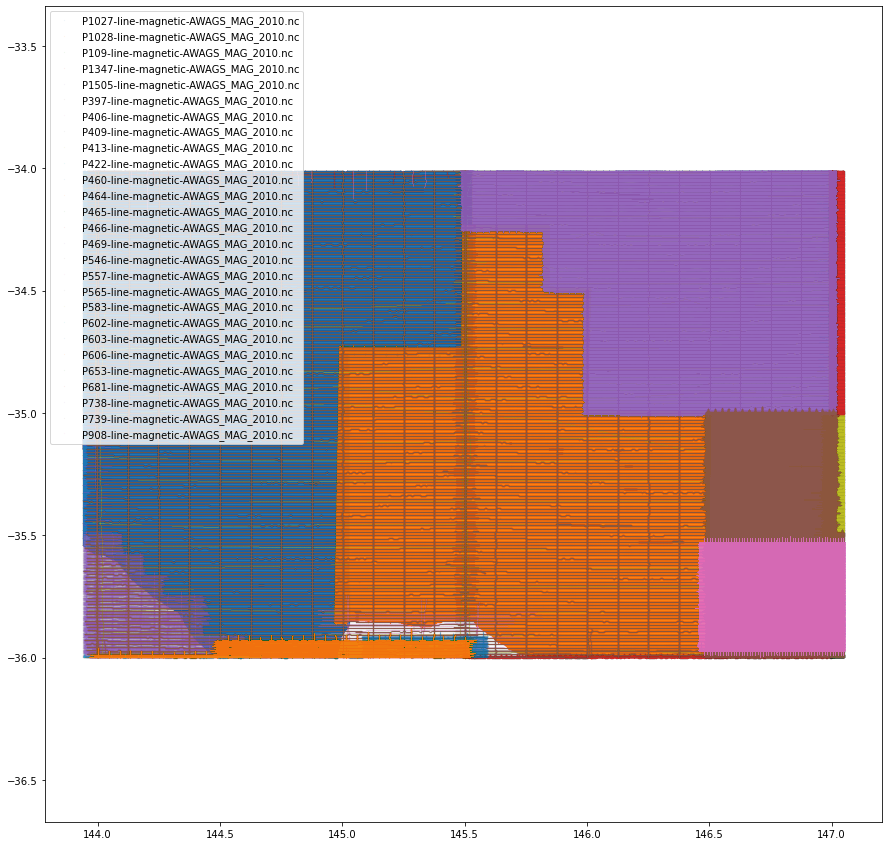

In [6]:
# Filter points from individual datasets and plot their dataset name
# Only use points where gridflag == 'Station used in the production of GA grids.'
coordinate_list = []
value_list = []

fig = plt.figure(figsize=(15, 15))

for dataset in sorted(dataset_values.keys()):
    coordinates = dataset_values[dataset]["coordinates"][:]
    if len(coordinates):
        coordinate_list.append(coordinates)
        value_list.append(dataset_values[dataset].get(grid_var))
        plt.plot(
            coordinates[:, 0],
            coordinates[:, 1],
            ".",
            label=Path(dataset).name,
            markersize=0.05,
        )
plt.axis("equal")
plt.legend(loc='upper left')


In [7]:
nc = doggo.fetch("P413-line-magnetic-AWAGS_MAG_2010.nc")

In [8]:
# plot_survey_points(nc, grid_var)

## Single file gridding

In [71]:
netCDF4.Dataset(nc).variables.keys()

dict_keys(['line_index', 'line', 'bearing', 'dateCode', 'flight', 'levelFlag', 'lineType', 'survey', 'FID', 'latitude_AGD66', 'longitude_AGD66', 'mag_awagsLevelled', 'mag_microLevelled', 'mag_tieLevelled', 'longitude', 'latitude', 'crs'])

In [10]:
spacing = 500 # m

xr_data = xr.open_dataset(nc)  # ; data.set_coords(["latitude", "longitude"])
lat = "latitude" #.upper()
lon = "longitude" #.upper()
dat = "mag_awagsLevelled" if "Mag" in theme else "freeair"
data = pd.DataFrame(
    data={
        "latitude": xr_data.get(lat).values,
        "longitude": xr_data.get(lon).values,
        "grid_var": xr_data.get(dat).values,
    }
)

data.dropna(inplace=True) # Some datasets have nans...

utm_crs_list = pyproj.database.query_utm_crs_info(
    datum_name="WGS 84",
    area_of_interest=pyproj.aoi.AreaOfInterest(*GDA94_bounds),
)
epsg = utm_crs_list[0].code  # pyproj.CRS.from_epsg( )
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
proj_coords = projection(data.longitude.values, data.latitude.values)



In [11]:

# reducer = vd.BlockReduce(np.median, spacing=spacing)
# filter_coords, filter_data = reducer.filter(proj_coords, data.grid_var)

# spline = vd.Spline(mindist=100e3).fit(filter_coords, filter_data)
# grid = spline.grid(spacing=spacing, data_names=grid_var)

# grid = vd.distance_mask(proj_coords, maxdist=spacing * 5, grid=grid)

# plt.figure(figsize=(10, 30), constrained_layout=True)
# plt.title(f"Gridded {grid_var} in Cartesian coordinates")
# pc = grid[grid_var].plot.pcolormesh(cmap=cc.cm.CET_L16, add_colorbar=True)
# plt.plot(filter_coords[0], filter_coords[1], ".k", markersize=0.5)
# plt.xlabel("Easting (m)")
# plt.ylabel("Northing (m)")
# plt.gca().set_aspect("equal")
# plt.show()


In [12]:
chain = vd.Chain(
    [
        ("median", vd.BlockReduce(np.median, spacing=spacing)),
        #   ("trend", vd.Trend(degree=1)),
        (
            "spline",
            vd.SplineCV(
                dampings=[None], #1e-10, 1e-1, 
                mindists=[1000], #, 10e3
                delayed=True,
            ),
        ),
    ],
)
train, test = vd.train_test_split(
    proj_coords, data.freeair, random_state=0, spacing=spacing
)
chain.fit(*train)
score = chain.score(*test)

print("\nBest spline configuration:")
# print(f"\nScore: {chain.named_steps['spline'].scores_:.3f}")
print("mindist:", chain.named_steps["spline"].mindist_)
print("damping:", chain.named_steps["spline"].damping_)

grid_full = chain.grid(
    # region=projection(*region),
    spacing=spacing,
    # projection=projection,
    dims=["Easting", "Northing"],
    data_names=grid_var,
)

chain_grid = vd.distance_mask(proj_coords, grid=grid_full, maxdist=spacing * 5)


C:\Users\Luke\Miniconda3\envs\srvey\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Luke\Miniconda3\envs\srvey\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Luke\Miniconda3\envs\srvey\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 


Best spline configuration:
mindist: 100000.0
damping: None


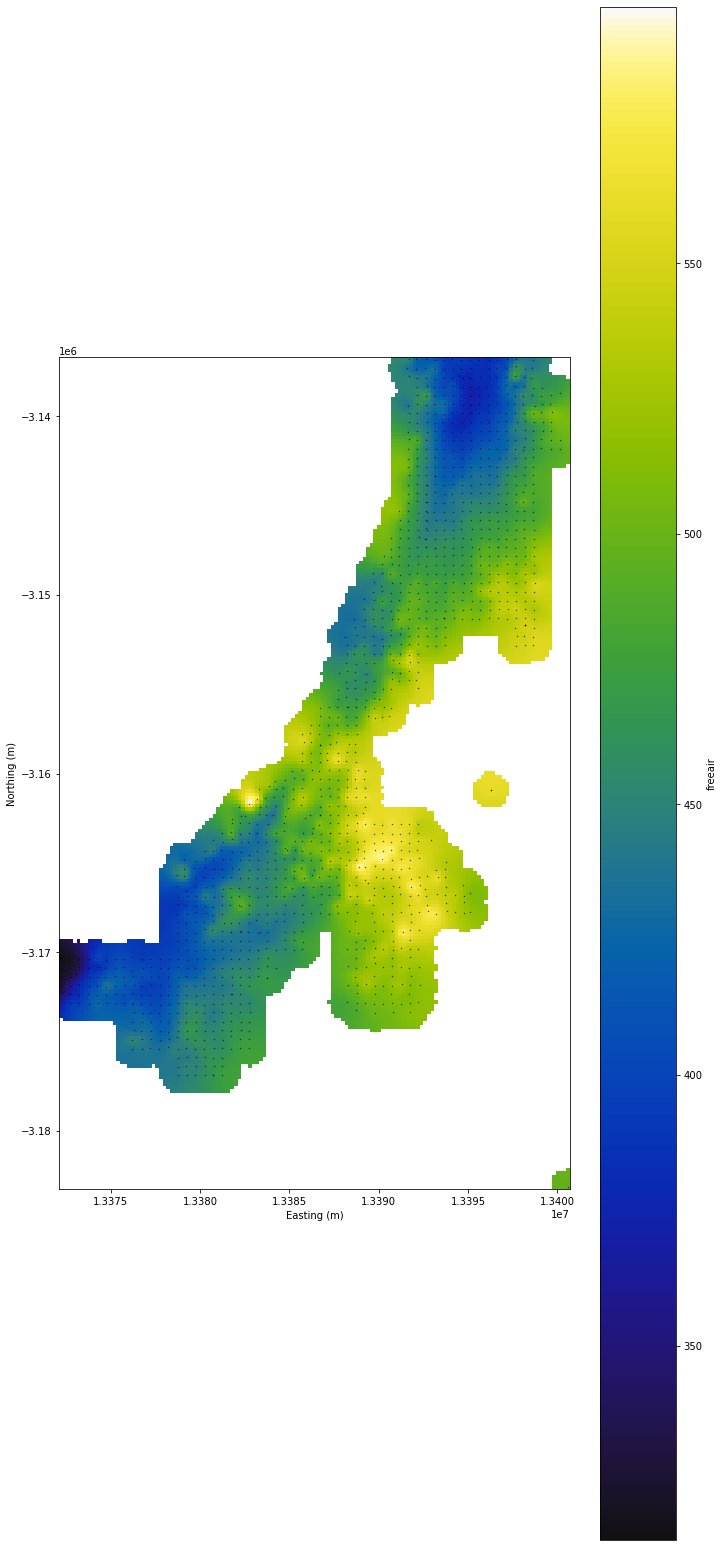

In [38]:
# Plot the grid and the original data points
plt.figure(figsize=(10, 30), constrained_layout=True)
plt.title("Gridded free air gravity in Cartesian coordinates")
pc = chain_grid.freeair.plot.pcolormesh(cmap=cc.cm.CET_L16, add_colorbar=True)
plt.scatter(*proj_coords, c="k", s=0.1)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")

plt.show()


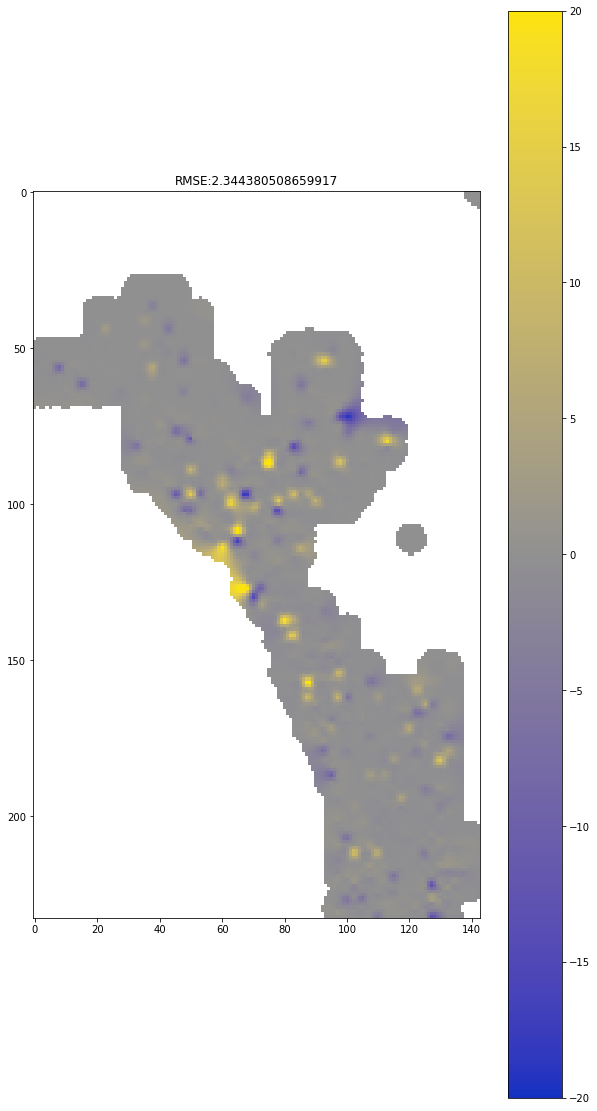

In [39]:
plt.figure(figsize=(10, 20))
plt.title(
    f"RMSE:{np.sqrt(np.nanmean((grid.freeair.values - chain_grid.freeair.values)**2))}"
)
plt.imshow(
    grid.freeair.values - chain_grid.freeair.values,
    cmap=cc.cm.CET_D7,
    vmin=-20,
    vmax=20,
)
plt.colorbar()


## Compilation Gridding

In [22]:
coordinate_list = []
value_list = []

for dataset in sorted(dataset_values.keys()):
    coordinates = dataset_values[dataset]["coordinates"][:]
    if len(coordinates):
        coordinate_list.extend(coordinates)
        value_list.extend(dataset_values[dataset].get(grid_var))
coordinate_list = np.array(coordinate_list)
value_list = np.array(value_list)

compilation_data = pd.DataFrame(
    data={"latitude": coordinate_list[:,1], "longitude": coordinate_list[:,0], "freeair":value_list}
)
data = compilation_data